C:\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Populating the interactive namespace from numpy and matplotlib


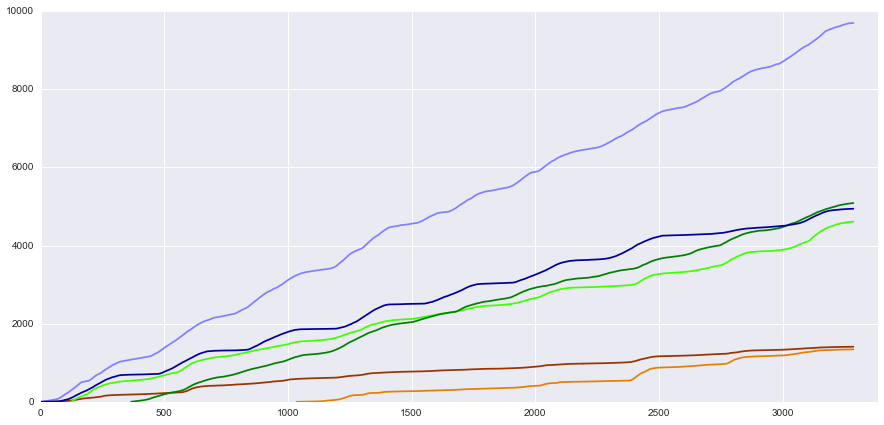

In [1]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats


# Directory with daily files for the figure
fluxfileDir = 'C:\\Research\\NASA_USDA-NIFA_ROSES_2016\\'

# Color scheme
gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [gcolour, scolour, jcolour, pjcolour, pcolour, mcolour]

# Filenames of each daily file
seg = 'US-Sen_2007_2016_daily.txt'
ses = 'US-Ses_2007_2016_daily.txt'
wjs = 'US-Wjs_2007_2016_daily.txt'

mpj = 'US-Mpj_2007_2016_daily.txt'
vcp = 'US-Vcp_2007_2016_daily.txt'
vcm = 'US-Vcm_2007_2016_daily.txt'

# Read in and concat each file with an extra column, SITE
Seg = pd.read_csv(fluxfileDir + seg, sep = '\t')
Ses = pd.read_csv(fluxfileDir + ses, sep = '\t')
Wjs = pd.read_csv(fluxfileDir + wjs, sep = '\t')

Mpj = pd.read_csv(fluxfileDir + mpj, sep = '\t')
Vcp = pd.read_csv(fluxfileDir + vcp, sep = '\t')
Vcm = pd.read_csv(fluxfileDir + vcm, sep = '\t')
Seg[Seg == -9999] = np.nan

Seg['SITE'] = 'Seg'
Ses['SITE'] = 'Ses'
Wjs['SITE'] = 'Wjs'

Mpj['SITE'] = 'Mpj'
Vcp['SITE'] = 'Vcp'
Vcm['SITE'] = 'Vcm'

# Concatenate files into single pandas df
# then replace -9999 with NaN
fluxdf = pd.concat([Seg, Ses, Wjs, Mpj, Vcp, Vcm])
fluxdf[fluxdf == -9999] = np.nan

# Setup a color palette for the sites
forestTS = ['#d8b365','#91bfdb','#5ab4ac','#d8b365','#91bfdb','#5ab4ac']

# Quick cumulative comparison
f, (ax) = plt.subplots(1,1, figsize = (15, 7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = fluxdf[fluxdf.SITE == site]
    siteflux.GPP.cumsum().plot(ax = ax, color = siteColors[idx])
    idx = idx + 1

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
sns.despine()

Mpj 18    2010
Name: year, dtype: int64 796.47010093 36    2013
Name: year, dtype: int64 547.472067963
Seg 37    2013
Name: year, dtype: int64 370.692689394 13    2009
Name: year, dtype: int64 6.329974058
Ses 8    2008
Name: year, dtype: int64 231.64280494 26    2011
Name: year, dtype: int64 78.293081027
Vcm 3    2007
Name: year, dtype: int64 694.41954209 45    2014
Name: year, dtype: int64 202.126472892
Vcp 22    2010
Name: year, dtype: int64 1183.25200203 28    2011
Name: year, dtype: int64 883.42774116
Wjs 53    2015
Name: year, dtype: int64 759.068819671 29    2011
Name: year, dtype: int64 354.211255887


C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


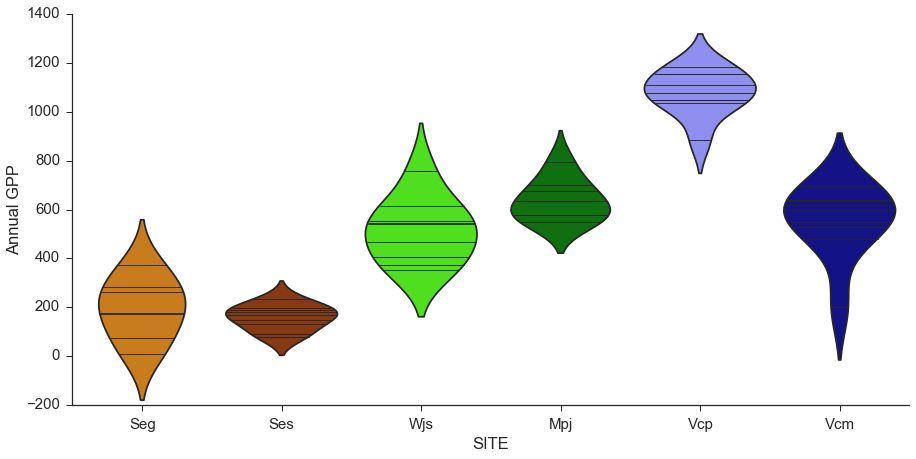

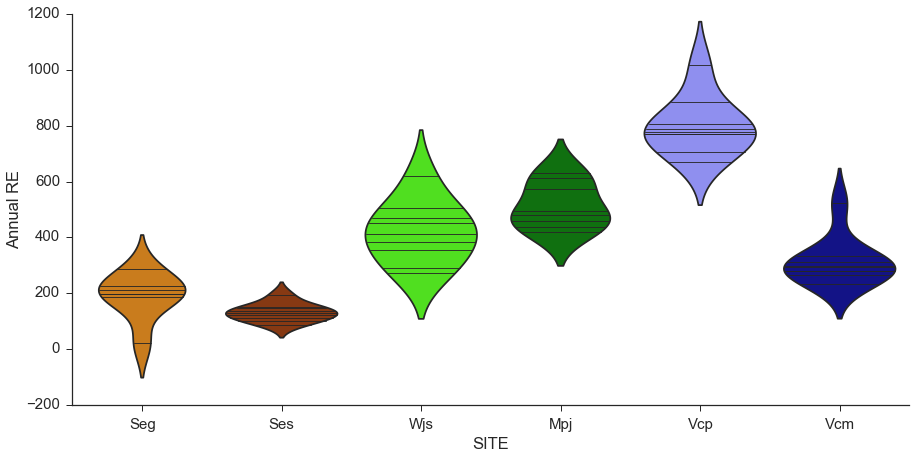

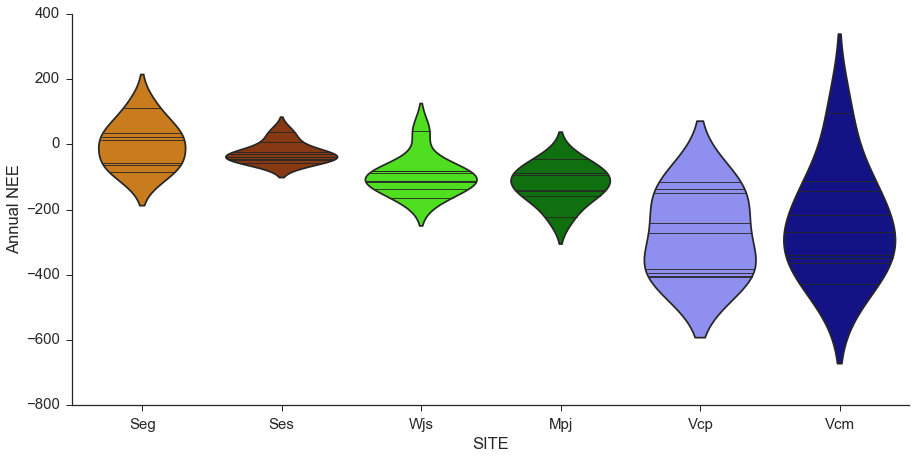

In [2]:
annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

for site in np.unique(annualSums.SITE):
    maxgpp = annualSums[annualSums.SITE == site].GPP.max()
    mingpp = annualSums[annualSums.SITE == site].GPP.min()
    yearofMax = annualSums[annualSums.GPP == maxgpp].year
    yearofMin = annualSums[annualSums.GPP == mingpp].year
    print site, yearofMax, maxgpp, yearofMin, mingpp
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="GPP",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual GPP')
sns.despine()

plt.savefig('AnnualGPPDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="RECO",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual RE')
sns.despine()

plt.savefig('AnnualREDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="FC_F",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual NEE')
sns.despine()

plt.savefig('AnnualNEEDistro.tif')

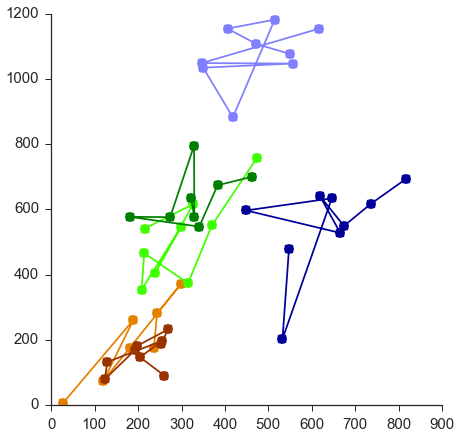

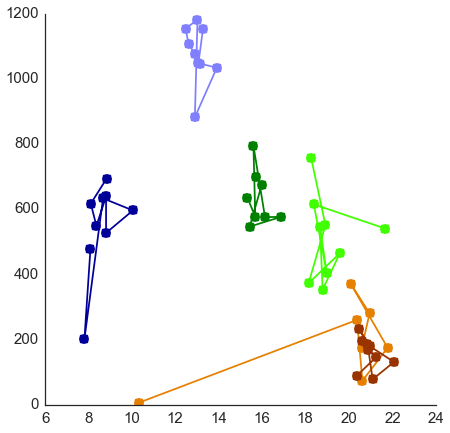

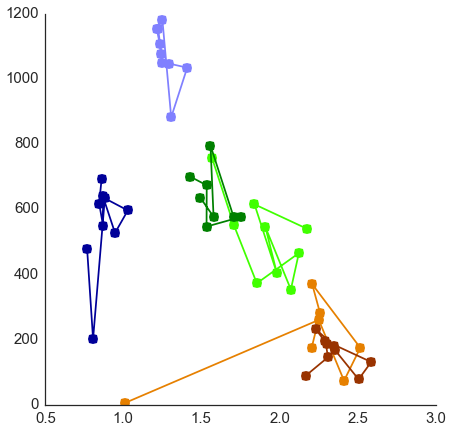

In [3]:
f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = annualSums[annualSums.SITE == site]
    ax1.plot(siteflux['P_F'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxPRECIP.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['TA_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxTA_MAX.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['VPD_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxVPDMAX.tif')


In [4]:

#######

segH = Seg[Seg.HY == 2010]
segL = Seg[Seg.HY == 2011]
segH['status'] = 'Wet year'
segL['status'] = 'Dry year'

sesH = Ses[Ses.HY == 2010]
sesL = Ses[Ses.HY == 2011]
sesH['status'] = 'Wet year'
sesL['status'] = 'Dry year'

wjsH = Wjs[Wjs.HY == 2010]
wjsL = Wjs[Wjs.HY == 2011]
wjsH['status'] = 'Wet year'
wjsL['status'] = 'Dry year'


mpjH = Mpj[Mpj.HY == 2010]
mpjL = Mpj[Mpj.HY == 2011]
mpjH['status'] = 'Wet year'
mpjL['status'] = 'Dry year'

vcpH = Vcp[Vcp.HY == 2010]
vcpL = Vcp[Vcp.HY == 2011]
vcpH['status'] = 'Wet year'
vcpL['status'] = 'Dry year'

vcmH = Vcm[Vcm.HY == 2010]
vcmL = Vcm[Vcm.HY == 2011]
vcmH['status'] = 'Wet year'
vcmL['status'] = 'Dry year'

highLow = pd.concat([vcmH,vcmL,vcpH,vcpL,mpjH,mpjL,wjsH,wjsL,sesH,sesL,segH,segL])
highLowSum = highLow.groupby(['SITE','status','HY']).sum().reset_index()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Ana

In [5]:
highLow[highLow.SITE == 'Seg'].HY.size

730

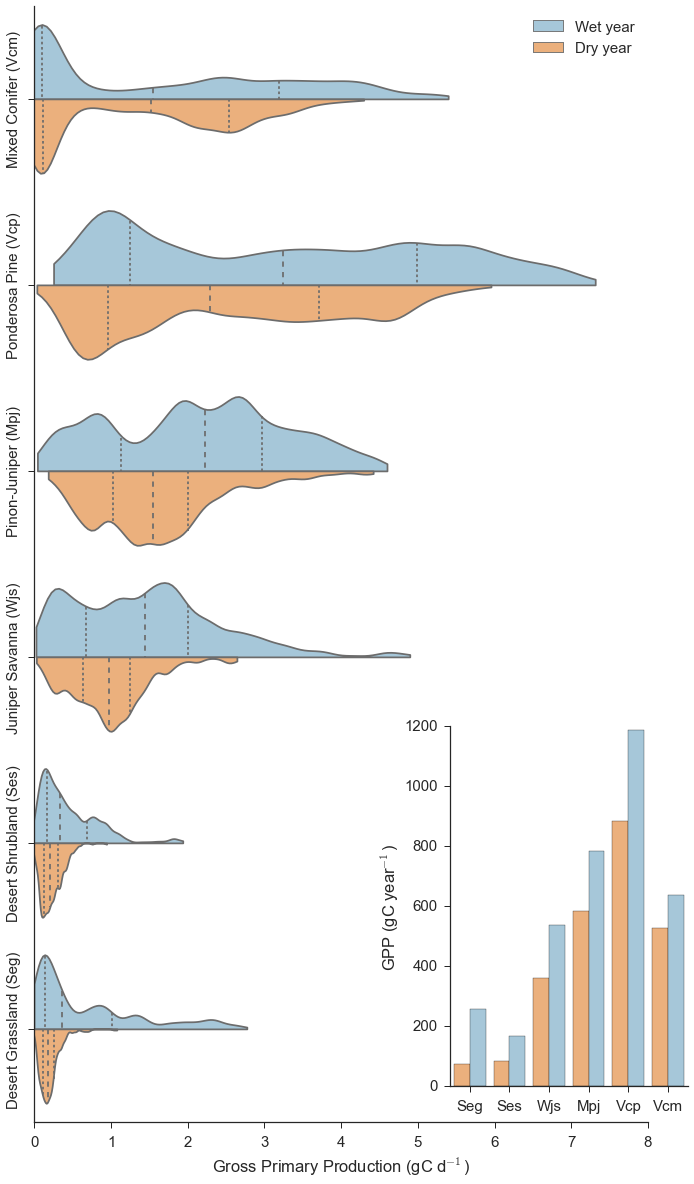

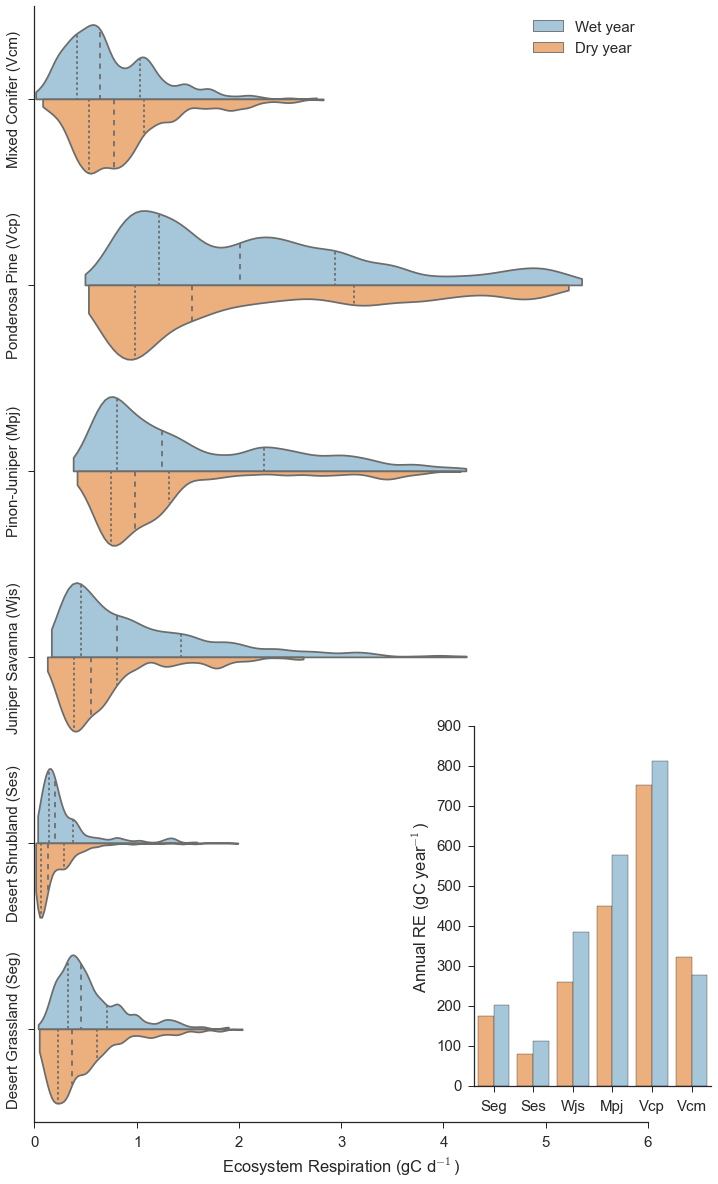

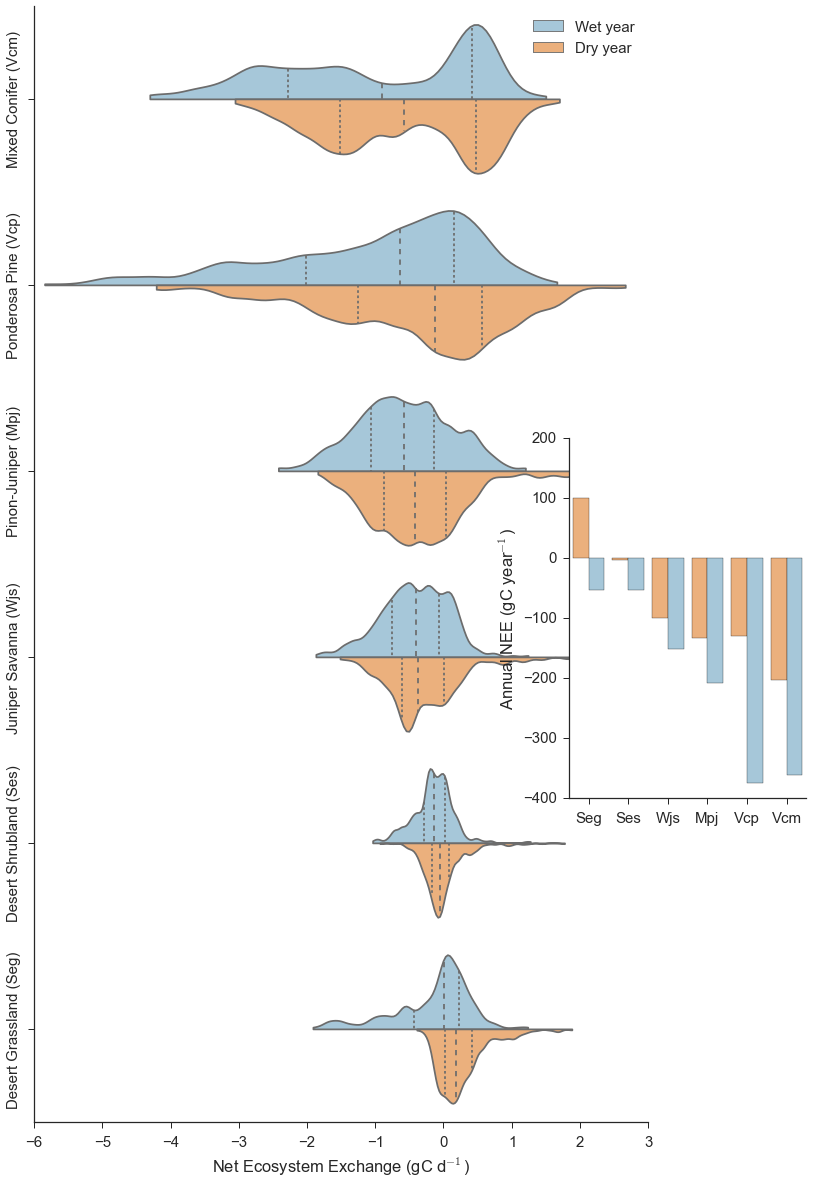

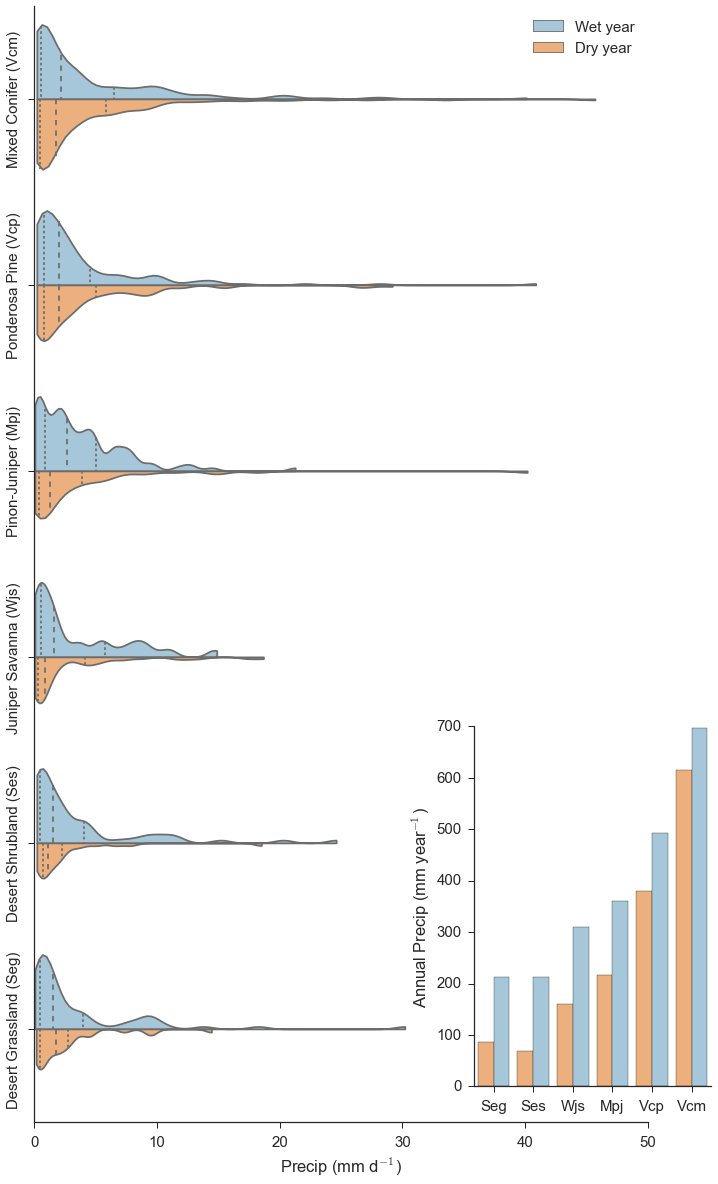

In [251]:
f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="GPP", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.65, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="GPP", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('GPP (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Gross Primary Production (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtGPP.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="RECO", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="RECO", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual RE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Ecosystem Respiration (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtRE.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="FC_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.80, 0.35, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="FC_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual NEE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Net Ecosystem Exchange (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtNEE.tif')




# Set days with no rain to NaN
highLow[highLow.P_F <= 0] = np.nan


f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="P_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="P_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual Precip (mm year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Precip (mm d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtPRECIP.tif')

Seg
Ses
Wjs
Mpj
Vcp
Vcm


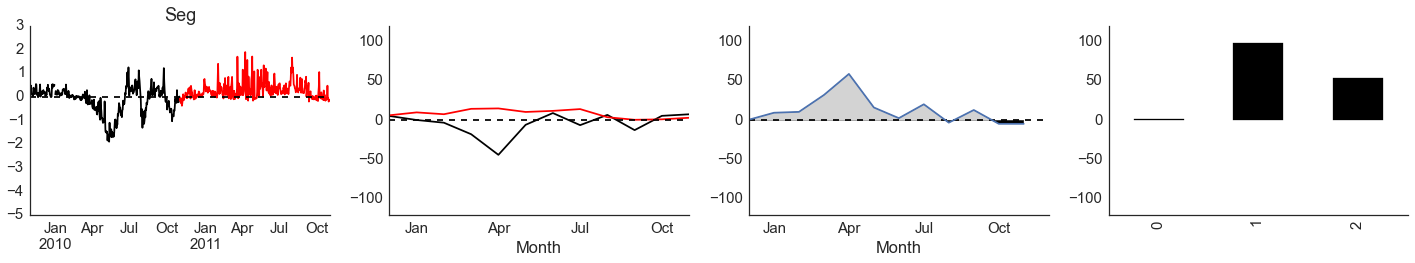

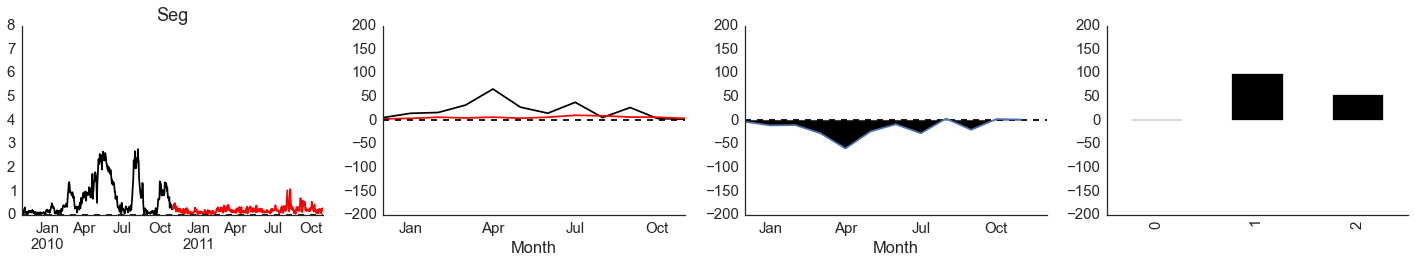

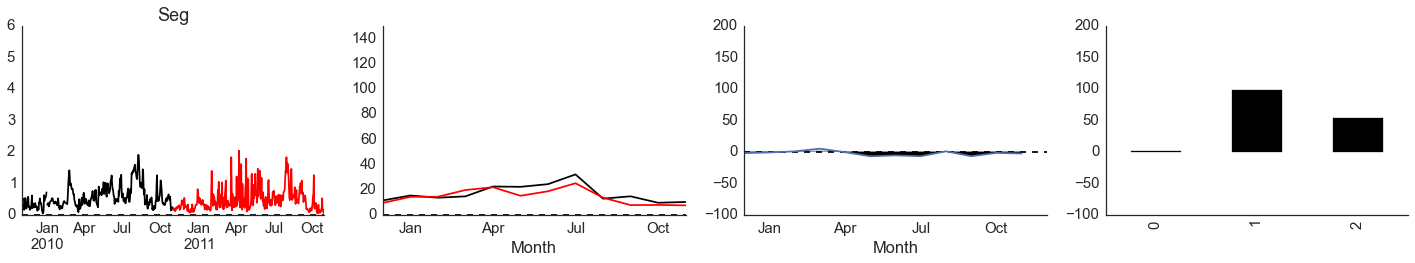

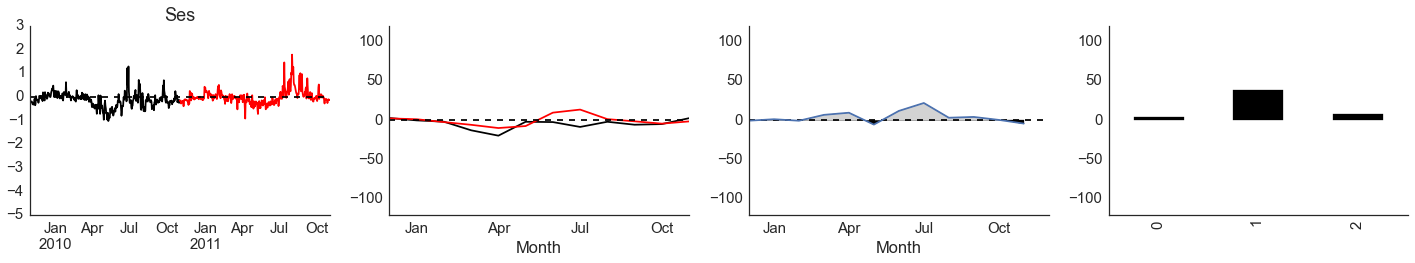

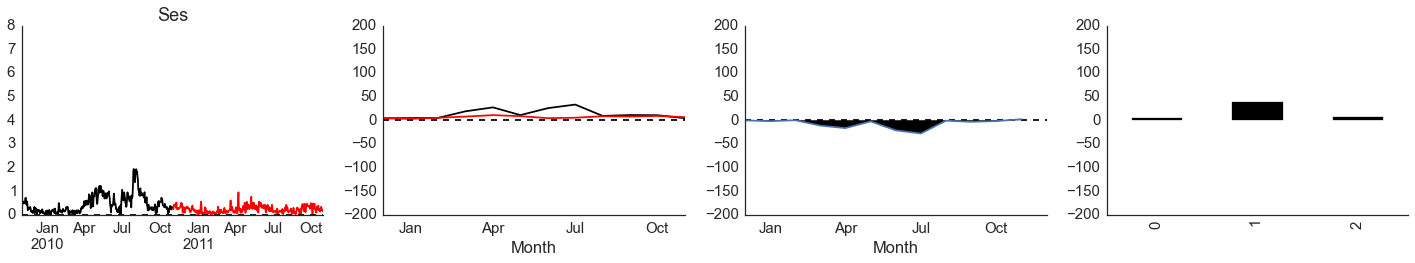

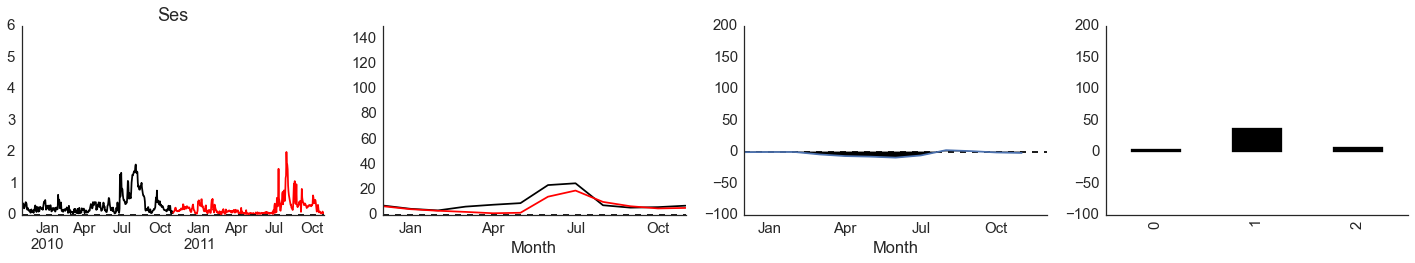

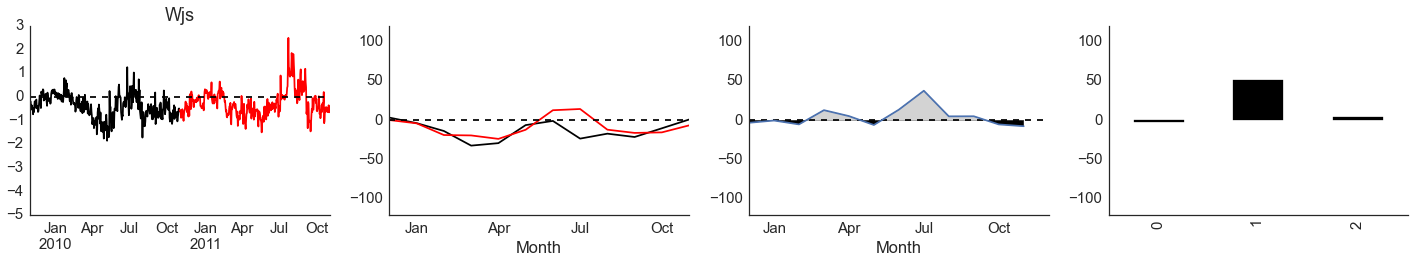

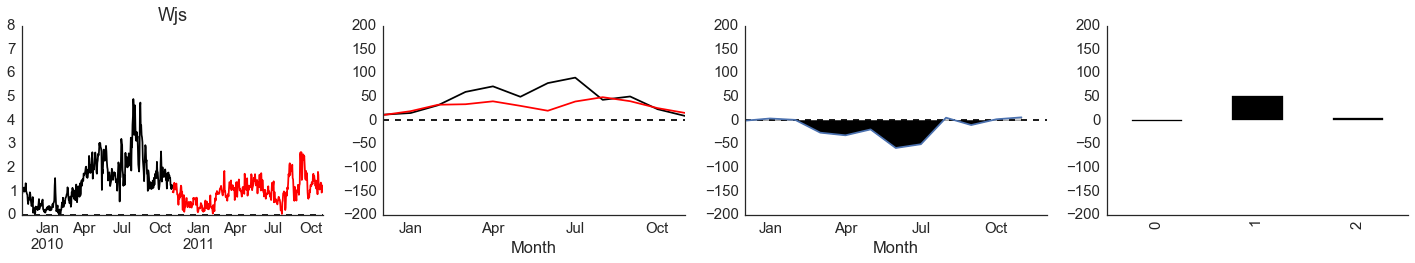

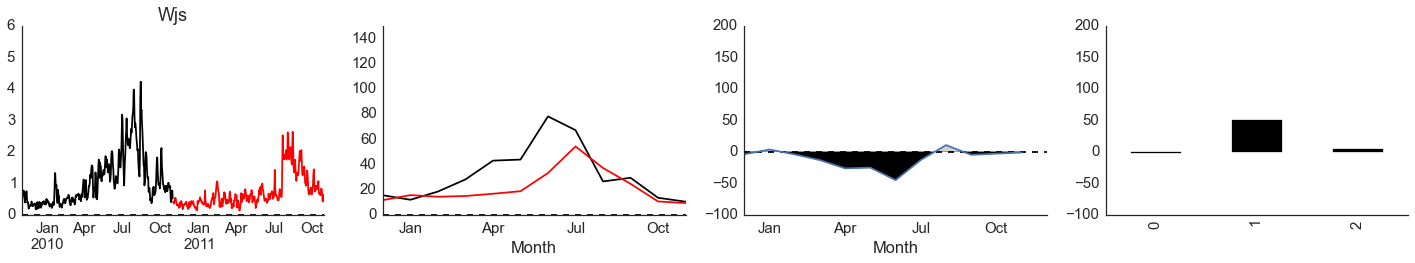

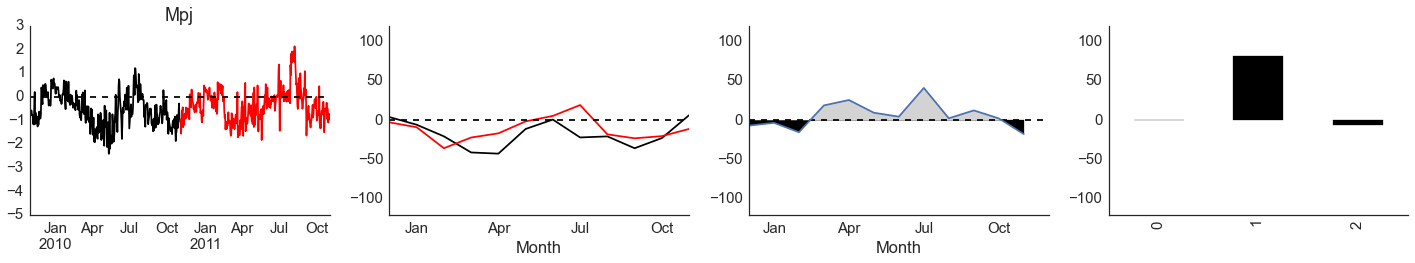

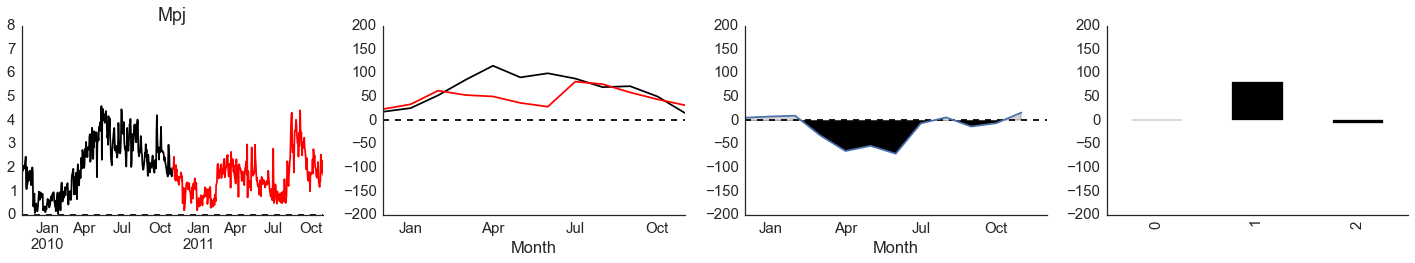

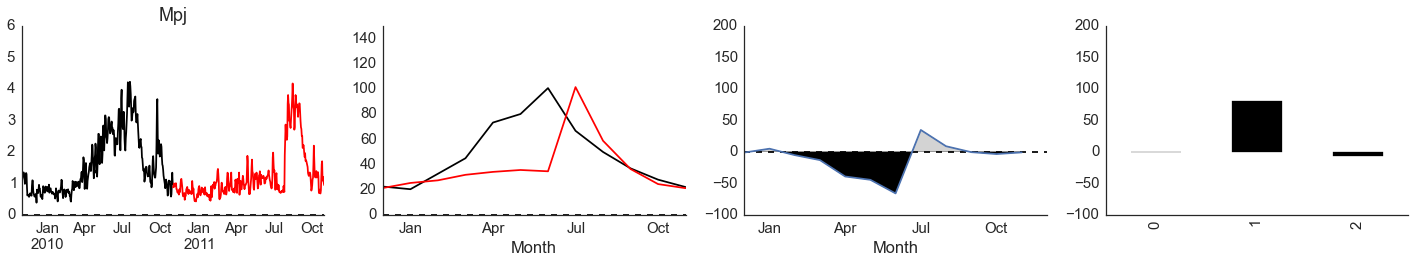

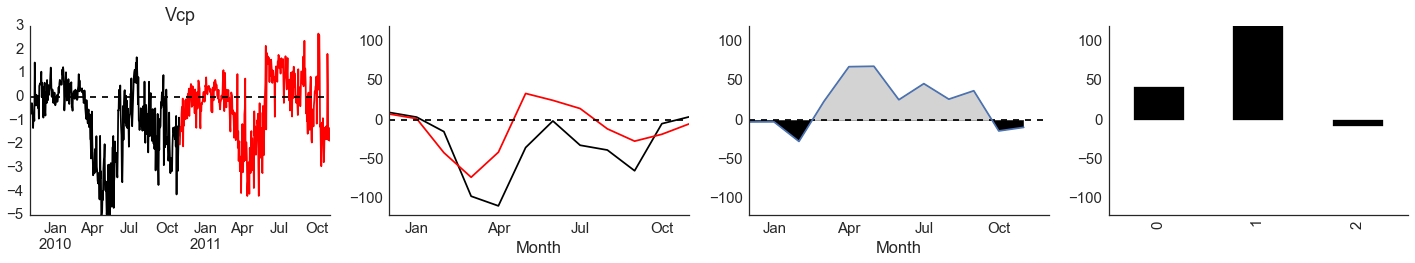

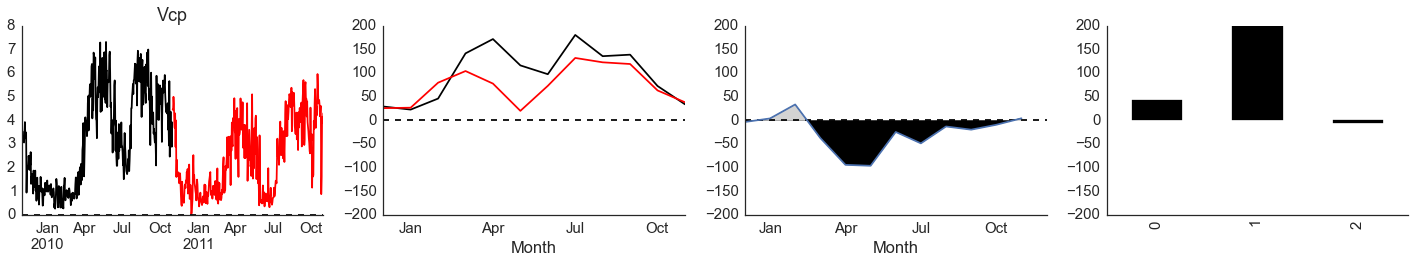

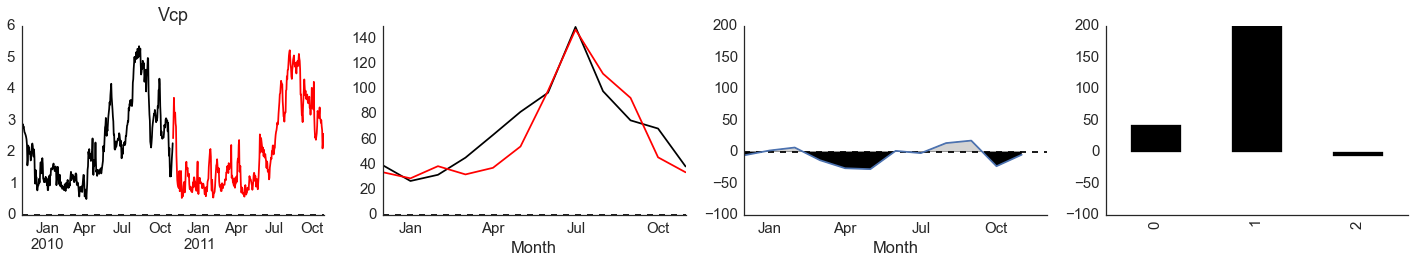

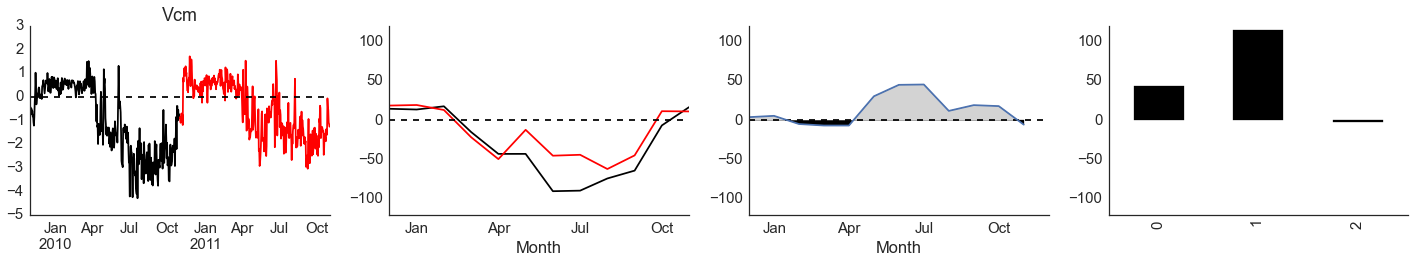

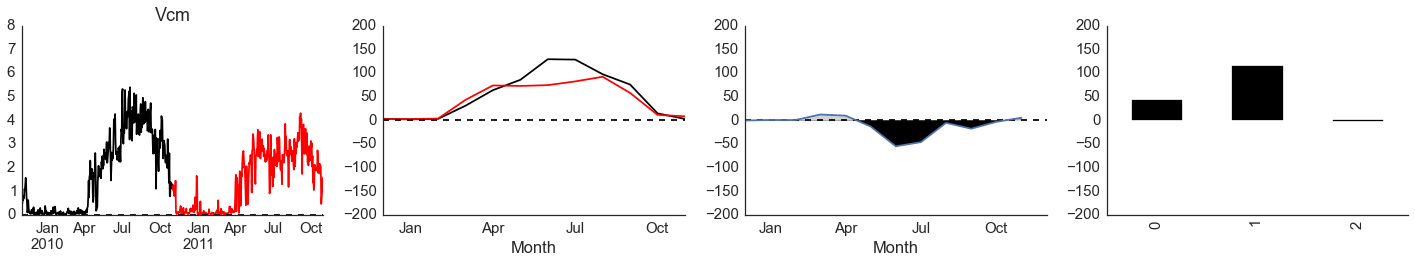

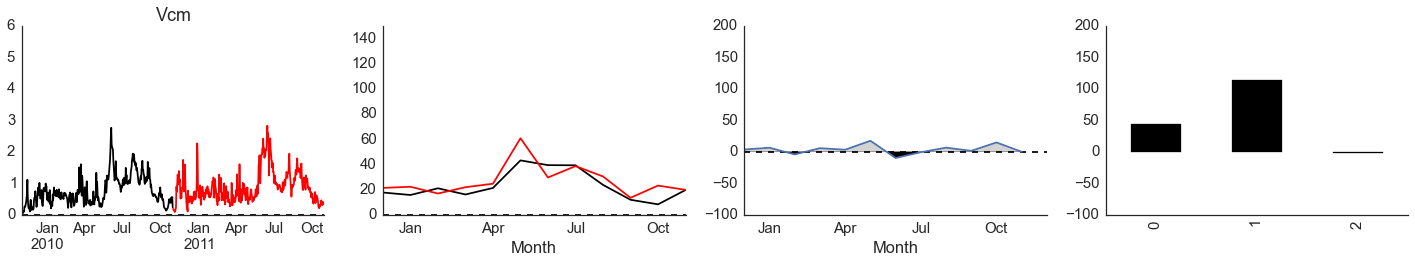

In [11]:
monthOrder = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']

import warnings
warnings.filterwarnings('ignore')

idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    
    thisSite = highLow[highLow.SITE == site]
    thisSite['Season'] = 'Winter'
    wetYear = thisSite[thisSite.status == 'Wet year']
    dryYear = thisSite[thisSite.status == 'Dry year']
    print site

    wetYear.index = pd.date_range('2009-11-1','2010-10-31')
    dryYear.index = pd.date_range('2010-11-1','2011-10-31')
    
    wetYear['MonthName'] = 'Jan'
    wetYear.MonthName[wetYear.month == 1] = 'Nov'
    wetYear.MonthName[wetYear.month == 2] = 'Dec'
    wetYear.MonthName[wetYear.month == 3] = 'Jan'
    wetYear.MonthName[wetYear.month == 4] = 'Feb'
    wetYear.MonthName[wetYear.month == 5] = 'Mar'
    wetYear.MonthName[wetYear.month == 6] = 'Apr'
    wetYear.MonthName[wetYear.month == 7] = 'May'
    wetYear.MonthName[wetYear.month == 8] = 'Jun'
    wetYear.MonthName[wetYear.month == 9] = 'Jul'
    wetYear.MonthName[wetYear.month == 10] = 'Aug'
    wetYear.MonthName[wetYear.month == 11] = 'Sep'
    wetYear.MonthName[wetYear.month == 12] = 'Oct'
    wetYear.MonthName = wetYear['MonthName'].astype('category')
    wetYear['MonthName'].cat.reorder_categories(monthOrder)

    wetYear['hydMonth'] = 1
    wetYear.hydMonth[wetYear.MonthName == 'Nov'] = 1
    wetYear.hydMonth[wetYear.MonthName == 'Dec'] = 2
    wetYear.hydMonth[wetYear.MonthName == 'Jan'] = 3
    wetYear.hydMonth[wetYear.MonthName == 'Feb'] = 4
    wetYear.hydMonth[wetYear.MonthName == 'Mar'] = 5
    wetYear.hydMonth[wetYear.MonthName == 'Apr'] = 6
    wetYear.hydMonth[wetYear.MonthName == 'May'] = 7
    wetYear.hydMonth[wetYear.MonthName == 'Jun'] = 8
    wetYear.hydMonth[wetYear.MonthName == 'Jul'] = 9
    wetYear.hydMonth[wetYear.MonthName == 'Aug'] = 10
    wetYear.hydMonth[wetYear.MonthName == 'Sep'] = 11
    wetYear.hydMonth[wetYear.MonthName == 'Oct'] = 12

    dryYear['MonthName'] = 'Jan'
    dryYear['hydMonth'] = 1
    dryYear.MonthName[dryYear.month == 1] = 'Nov'
    dryYear.MonthName[dryYear.month == 2] = 'Dec'
    dryYear.MonthName[dryYear.month == 3] = 'Jan'
    dryYear.MonthName[dryYear.month == 4] = 'Feb'
    dryYear.MonthName[dryYear.month == 5] = 'Mar'
    dryYear.MonthName[dryYear.month == 6] = 'Apr'
    dryYear.MonthName[dryYear.month == 7] = 'May'
    dryYear.MonthName[dryYear.month == 8] = 'Jun'
    dryYear.MonthName[dryYear.month == 9] = 'Jul'
    dryYear.MonthName[dryYear.month == 10] = 'Aug'
    dryYear.MonthName[dryYear.month == 11] = 'Sep'
    dryYear.MonthName[dryYear.month == 12] = 'Oct'
    dryYear.MonthName = dryYear['MonthName'].astype('category')
    dryYear['MonthName'].cat.reorder_categories(monthOrder)

    dryYear.hydMonth[dryYear.MonthName == 'Nov'] = 1
    dryYear.hydMonth[dryYear.MonthName == 'Dec'] = 2
    dryYear.hydMonth[dryYear.MonthName == 'Jan'] = 3
    dryYear.hydMonth[dryYear.MonthName == 'Feb'] = 4
    dryYear.hydMonth[dryYear.MonthName == 'Mar'] = 5
    dryYear.hydMonth[dryYear.MonthName == 'Apr'] = 6
    dryYear.hydMonth[dryYear.MonthName == 'May'] = 7
    dryYear.hydMonth[dryYear.MonthName == 'Jun'] = 8
    dryYear.hydMonth[dryYear.MonthName == 'Jul'] = 9
    dryYear.hydMonth[dryYear.MonthName == 'Aug'] = 10
    dryYear.hydMonth[dryYear.MonthName == 'Sep'] = 11
    dryYear.hydMonth[dryYear.MonthName == 'Oct'] = 12

    dryYear['Season'] = 'Winter'
    dryYear.Season[dryYear.hydMonth < 5] ='Winter'
    dryYear.Season[(dryYear.hydMonth > 4) & (dryYear.hydMonth < 9)] ='Spring'
    dryYear.Season[dryYear.hydMonth > 8] ='Monsoon'

    wetYear['Season'] = 'Winter'
    wetYear.Season[wetYear.hydMonth < 5] ='Winter'
    wetYear.Season[(wetYear.hydMonth > 4) & (wetYear.hydMonth < 9)] ='Spring'
    wetYear.Season[wetYear.hydMonth > 8] ='Monsoon'  
    
    wetMonths = wetYear.groupby([wetYear.index.month, 'Season']).sum()
    dryMonths = dryYear.groupby([dryYear.index.month, 'Season']).sum()
    
    diff =  dryMonths - wetMonths
    wetMonths['Zero'] = 0
    diff['Zero'] = 0
    diffS = diff.reset_index().groupby('Season').sum().reset_index()

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

    wetYear.FC_F.plot(ax = ax1, c = 'k')
    dryYear.FC_F.plot(ax = ax1, c = 'red')
    wetMonths.FC_F.plot(ax = ax2, c = 'k')
    dryMonths.FC_F.plot(ax = ax2, c = 'red')
    ax1.axhline(y=0, color = 'k', linestyle = '--')
    ax2.axhline(y=0, color = 'k', linestyle = '--')
    ax3.axhline(y=0, color = 'k', linestyle = '--')
    y2 = (dryMonths.FC_F - wetMonths.FC_F)
    
    y1 = wetMonths.Zero
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 <= y1, facecolor='k', interpolate=True)
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)

    diffS.FC_F.plot(x = 'Season', kind = 'bar', ax = ax4, color = 'k')
    #ax4.set_xticklabels(['Monsoon','Spring','Winter'])
    ax3.plot(dryMonths.FC_F - wetMonths.FC_F)

    ax2.set_xticks([1,4,7,10])
    ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax2.set_xlabel('Month')
    ax3.set_xticks([1,4,7,10])
    ax3.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax3.set_xlabel('Month')
    ax1.set_title(site)
    
    #### Axes
    ax1.set_ylim([-5,3])
    ax2.set_ylim([-120,120])
    ax3.set_ylim([-120,120])
    ax4.set_ylim([-120,120])
    
    #### DF creation for gradient wide averaging
    if idx == 0:
        diffDF = pd.DataFrame(dict(WD_Diff = y2, SITE = site))
    else:
        diff = pd.DataFrame(dict(WD_Diff = y2, SITE = site))
        diffDF = pd.concat([diffDF, diff])
    sns.despine()
    plt.tight_layout()
    plt.savefig('draftDroughts_FC_' + site + '.tif')
    
    #################################################################################
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

    wetYear.GPP.plot(ax = ax1, c = 'k')
    dryYear.GPP.plot(ax = ax1, c = 'red')
    wetMonths.GPP.plot(ax = ax2, c = 'k')
    dryMonths.GPP.plot(ax = ax2, c = 'red')
    ax1.axhline(y=0, color = 'k', linestyle = '--')
    ax2.axhline(y=0, color = 'k', linestyle = '--')
    ax3.axhline(y=0, color = 'k', linestyle = '--')
    y2 = (dryMonths.GPP - wetMonths.GPP)
    
    y1 = wetMonths.Zero
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 <= y1, facecolor='k', interpolate=True)
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)

    diffS.FC_F.plot(x = 'Season', kind = 'bar', ax = ax4, color = 'k')
    #ax4.set_xticklabels(['Monsoon','Spring','Winter'])
    ax3.plot(dryMonths.GPP - wetMonths.GPP)

    ax2.set_xticks([1,4,7,10])
    ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax2.set_xlabel('Month')
    ax3.set_xticks([1,4,7,10])
    ax3.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax3.set_xlabel('Month')
    ax1.set_title(site)
    
    #### Axes
    ax1.set_ylim([0,8])
    ax2.set_ylim([-200,200])
    ax3.set_ylim([-200,200])
    ax4.set_ylim([-200,200])
    sns.despine()
    plt.tight_layout()
    plt.savefig('draftDroughts_GPP_' + site + '.tif')

    #################################################################################

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

    wetYear.RECO.plot(ax = ax1, c = 'k')
    dryYear.RECO.plot(ax = ax1, c = 'red')
    wetMonths.RECO.plot(ax = ax2, c = 'k')
    dryMonths.RECO.plot(ax = ax2, c = 'red')
    ax1.axhline(y=0, color = 'k', linestyle = '--')
    ax2.axhline(y=0, color = 'k', linestyle = '--')
    ax3.axhline(y=0, color = 'k', linestyle = '--')
    y2 = (dryMonths.RECO - wetMonths.RECO)
    
    y1 = wetMonths.Zero
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 <= y1, facecolor='k', interpolate=True)
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)

    diffS.FC_F.plot(x = 'Season', kind = 'bar', ax = ax4, color = 'k')
    #ax4.set_xticklabels(['Monsoon','Spring','Winter'])
    ax3.plot(dryMonths.RECO - wetMonths.RECO)


    ax1.set_title(site)
    
    #### Axes
    ax1.set_ylim([0,6])
    ax2.set_ylim([0,150])
    ax3.set_ylim([-100,200])
    ax4.set_ylim([-100,200])
    
    ax2.set_xticks([1,4,7,10])
    ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax2.set_xlabel('Month')
    ax3.set_xticks([1,4,7,10])
    ax3.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax3.set_xlabel('Month')

    sns.despine()
    plt.tight_layout()
    plt.savefig('draftDroughts_RE_' + site + '.tif')

    idx = idx + 1
    
    


In [40]:
F_Unc = pd.read_csv('C:\Research\DinkeyCreek\FluxUncertainty.csv')

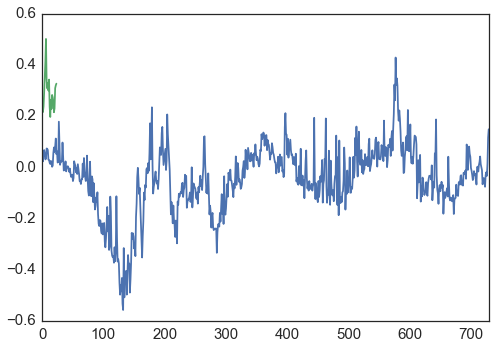

In [57]:
highLow['AREA_C'] = 9000000000
highLow.AREA_C[highLow.SITE == 'Vcp'] = 20000000000
highLow.AREA_C[highLow.SITE == 'Mpj'] = 50000000000
highLow.AREA_C[highLow.SITE == 'Wjs'] = 10000000000
highLow.AREA_C[highLow.SITE == 'Ses'] = 80000000000
highLow.AREA_C[highLow.SITE == 'Seg'] = 125400000000
highLow['weightedFC'] = highLow.FC_F * highLow.AREA_C / 10**12
highLow['weightedGPP'] = highLow.GPP * highLow.AREA_C / 10**12
highLow['weightedRE'] = highLow.RECO * highLow.AREA_C / 10**12

F_Unc['AREA_C'] = 9000000000
F_Unc.AREA_C[F_Unc.site == 'Vcp'] = 20000000000
F_Unc.AREA_C[F_Unc.site == 'Mpj'] = 50000000000
F_Unc.AREA_C[F_Unc.site == 'Wjs'] = 10000000000
F_Unc.AREA_C[F_Unc.site == 'Ses'] = 80000000000
F_Unc.AREA_C[F_Unc.site == 'Seg'] = 125400000000
F_Unc['weightedFCu'] = F_Unc.NEEu * F_Unc.AREA_C / 10**12
F_Unc['weightedGPPu'] = F_Unc.GPPu * F_Unc.AREA_C / 10**12
F_Unc['weightedREu'] = F_Unc.REu * F_Unc.AREA_C / 10**12


weightedSum = highLow.groupby(['HY','doy','month']).sum().reset_index()
weightedSum.weightedFC.plot()
weightedSum.index = pd.date_range('2009-11-1','2011-10-31')

F_Unc_Wsum = F_Unc.groupby(['HY','HydMonth']).sum().reset_index()

In [18]:
wetYear = weightedSum[weightedSum.HY == 2010] 
dryYear = weightedSum[weightedSum.HY == 2011] 

wetYear['MonthName'] = 'Jan'
wetYear.MonthName[wetYear.month == 1] = 'Nov'
wetYear.MonthName[wetYear.month == 2] = 'Dec'
wetYear.MonthName[wetYear.month == 3] = 'Jan'
wetYear.MonthName[wetYear.month == 4] = 'Feb'
wetYear.MonthName[wetYear.month == 5] = 'Mar'
wetYear.MonthName[wetYear.month == 6] = 'Apr'
wetYear.MonthName[wetYear.month == 7] = 'May'
wetYear.MonthName[wetYear.month == 8] = 'Jun'
wetYear.MonthName[wetYear.month == 9] = 'Jul'
wetYear.MonthName[wetYear.month == 10] = 'Aug'
wetYear.MonthName[wetYear.month == 11] = 'Sep'
wetYear.MonthName[wetYear.month == 12] = 'Oct'
wetYear.MonthName = wetYear['MonthName'].astype('category')
wetYear['MonthName'].cat.reorder_categories(monthOrder)

wetYear['hydMonth'] = 1
wetYear.hydMonth[wetYear.MonthName == 'Nov'] = 1
wetYear.hydMonth[wetYear.MonthName == 'Dec'] = 2
wetYear.hydMonth[wetYear.MonthName == 'Jan'] = 3
wetYear.hydMonth[wetYear.MonthName == 'Feb'] = 4
wetYear.hydMonth[wetYear.MonthName == 'Mar'] = 5
wetYear.hydMonth[wetYear.MonthName == 'Apr'] = 6
wetYear.hydMonth[wetYear.MonthName == 'May'] = 7
wetYear.hydMonth[wetYear.MonthName == 'Jun'] = 8
wetYear.hydMonth[wetYear.MonthName == 'Jul'] = 9
wetYear.hydMonth[wetYear.MonthName == 'Aug'] = 10
wetYear.hydMonth[wetYear.MonthName == 'Sep'] = 11
wetYear.hydMonth[wetYear.MonthName == 'Oct'] = 12

dryYear['MonthName'] = 'Jan'
dryYear['hydMonth'] = 1
dryYear.MonthName[dryYear.month == 1] = 'Nov'
dryYear.MonthName[dryYear.month == 2] = 'Dec'
dryYear.MonthName[dryYear.month == 3] = 'Jan'
dryYear.MonthName[dryYear.month == 4] = 'Feb'
dryYear.MonthName[dryYear.month == 5] = 'Mar'
dryYear.MonthName[dryYear.month == 6] = 'Apr'
dryYear.MonthName[dryYear.month == 7] = 'May'
dryYear.MonthName[dryYear.month == 8] = 'Jun'
dryYear.MonthName[dryYear.month == 9] = 'Jul'
dryYear.MonthName[dryYear.month == 10] = 'Aug'
dryYear.MonthName[dryYear.month == 11] = 'Sep'
dryYear.MonthName[dryYear.month == 12] = 'Oct'
dryYear.MonthName = dryYear['MonthName'].astype('category')
dryYear['MonthName'].cat.reorder_categories(monthOrder)

dryYear.hydMonth[dryYear.MonthName == 'Nov'] = 1
dryYear.hydMonth[dryYear.MonthName == 'Dec'] = 2
dryYear.hydMonth[dryYear.MonthName == 'Jan'] = 3
dryYear.hydMonth[dryYear.MonthName == 'Feb'] = 4
dryYear.hydMonth[dryYear.MonthName == 'Mar'] = 5
dryYear.hydMonth[dryYear.MonthName == 'Apr'] = 6
dryYear.hydMonth[dryYear.MonthName == 'May'] = 7
dryYear.hydMonth[dryYear.MonthName == 'Jun'] = 8
dryYear.hydMonth[dryYear.MonthName == 'Jul'] = 9
dryYear.hydMonth[dryYear.MonthName == 'Aug'] = 10
dryYear.hydMonth[dryYear.MonthName == 'Sep'] = 11
dryYear.hydMonth[dryYear.MonthName == 'Oct'] = 12

dryYear['Season'] = 'Winter'
dryYear.Season[dryYear.hydMonth < 5] ='Winter'
dryYear.Season[(dryYear.hydMonth > 4) & (dryYear.hydMonth < 9)] ='Spring'
dryYear.Season[dryYear.hydMonth > 8] ='Monsoon'

wetYear['Season'] = 'Winter'
wetYear.Season[wetYear.hydMonth < 5] ='Winter'
wetYear.Season[(wetYear.hydMonth > 4) & (wetYear.hydMonth < 9)] ='Spring'
wetYear.Season[wetYear.hydMonth > 8] ='Monsoon'

In [83]:
F_Unc_Wsum.weightedFCu[F_Unc_Wsum.HY == 2011].ravel()

array([ 0.23603573,  0.19704561,  0.26467837,  0.22856597,  0.28317457,
        0.27405296,  0.25652701,  0.21528187,  0.2304402 ,  0.30959573,
        0.32054833,  0.32725531])

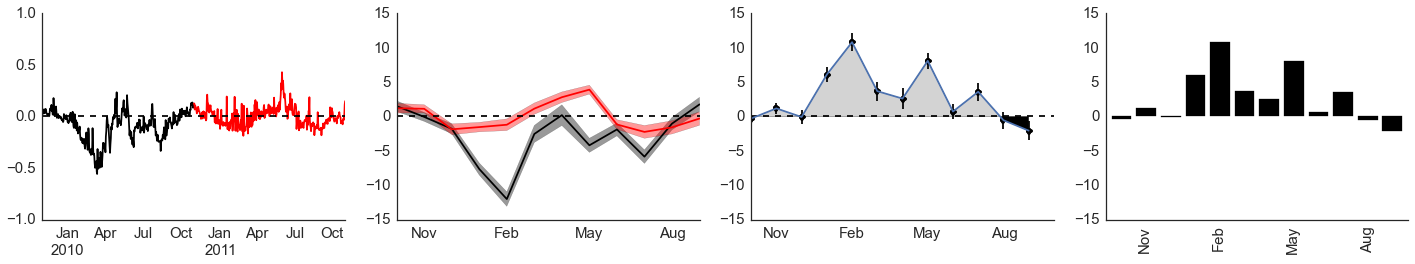

In [101]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetSum['FCu'] = F_Unc_Wsum.weightedFCu[F_Unc_Wsum.HY == 2010].ravel()
drySum['FCu'] = F_Unc_Wsum.weightedFCu[F_Unc_Wsum.HY == 2011].ravel()

wetYear.weightedFC.plot(ax = ax1, c = 'k')
dryYear.weightedFC.plot(ax = ax1, c = 'red')
wetSum.weightedFC.plot(ax = ax2, c = 'k')
drySum.weightedFC.plot(ax = ax2, c = 'red')

y1 = wetSum.weightedFC - (3 * wetSum.FCu)
y2 = wetSum.weightedFC + (3 * wetSum.FCu)
ax2.fill_between(wetSum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='k',
                 alpha = 0.4,
                 interpolate=True)

y1 = drySum.weightedFC - (3 * drySum.FCu)
y2 = drySum.weightedFC + (3 * drySum.FCu)
ax2.fill_between(drySum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='r',
                 alpha = 0.4,
                 interpolate=True)

ax1.axhline(y=0, color = 'k', linestyle = '--')
ax2.axhline(y=0, color = 'k', linestyle = '--')
ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (drySum.weightedFC - wetSum.weightedFC)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)
ax3.errorbar(np.arange(0,12,1), y2, yerr=2*(drySum.FCu + wetSum.FCu), fmt='o', color = 'k')
diffs = drySum.weightedFC - wetSum.weightedFC
diffs.plot(x = 'Season', kind = 'bar', width = 0.8, ax = ax4, color = 'k')
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(drySum.weightedFC - wetSum.weightedFC)

ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Nov','Feb','May','Aug'])
ax3.set_xticks([1,4,7,10])
ax3.set_xticklabels(['Nov','Feb','May','Aug'])
ax4.set_xticks([1,4,7,10])
ax4.set_xticklabels(['Nov','Feb','May','Aug'])

#### Axes
ax1.set_ylim([-1,1])
ax2.set_ylim([-15,15])
ax3.set_ylim([-15,15])
ax4.set_ylim([-15,15])

sns.despine()
plt.tight_layout()
plt.savefig('weightedSum_FC_oneway.tif', dpi = 300)

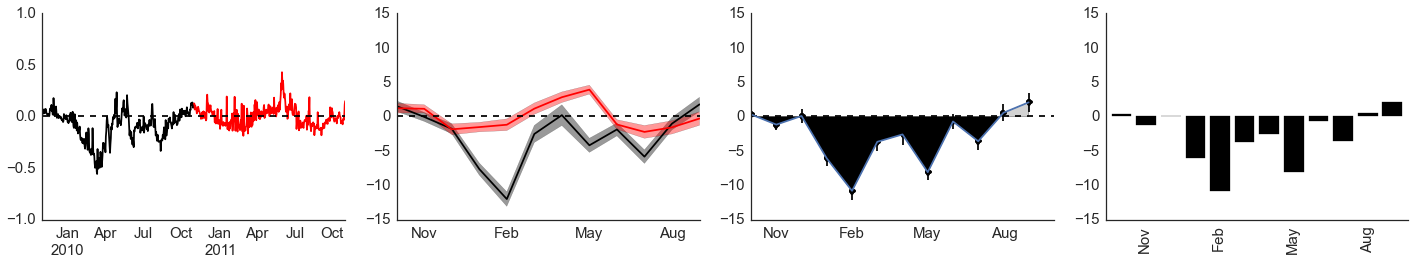

In [105]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetSum['FCu'] = F_Unc_Wsum.weightedFCu[F_Unc_Wsum.HY == 2010].ravel()
drySum['FCu'] = F_Unc_Wsum.weightedFCu[F_Unc_Wsum.HY == 2011].ravel()

wetYear.weightedFC.plot(ax = ax1, c = 'k')
dryYear.weightedFC.plot(ax = ax1, c = 'red')
wetSum.weightedFC.plot(ax = ax2, c = 'k')
drySum.weightedFC.plot(ax = ax2, c = 'red')

y1 = wetSum.weightedFC - (3 * wetSum.FCu)
y2 = wetSum.weightedFC + (3 * wetSum.FCu)
ax2.fill_between(wetSum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='k',
                 alpha = 0.4,
                 interpolate=True)

y1 = drySum.weightedFC - (3 * drySum.FCu)
y2 = drySum.weightedFC + (3 * drySum.FCu)
ax2.fill_between(drySum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='r',
                 alpha = 0.4,
                 interpolate=True)

ax1.axhline(y=0, color = 'k', linestyle = '--')
ax2.axhline(y=0, color = 'k', linestyle = '--')
ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (wetSum.weightedFC - drySum.weightedFC)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)
ax3.errorbar(np.arange(0,12,1), y2, yerr=2*(drySum.FCu + wetSum.FCu), fmt='o', color = 'k')
diffs = wetSum.weightedFC - drySum.weightedFC
diffs.plot(x = 'Season', kind = 'bar', width = 0.8, ax = ax4, color = 'k')
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(wetSum.weightedFC - drySum.weightedFC)

ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Nov','Feb','May','Aug'])
ax3.set_xticks([1,4,7,10])
ax3.set_xticklabels(['Nov','Feb','May','Aug'])
ax4.set_xticks([1,4,7,10])
ax4.set_xticklabels(['Nov','Feb','May','Aug'])

#### Axes
ax1.set_ylim([-1,1])
ax2.set_ylim([-15,15])
ax3.set_ylim([-15,15])
ax4.set_ylim([-15,15])

sns.despine()
plt.tight_layout()
plt.savefig('weightedSum_FC_theotherway.tif', dpi = 300)

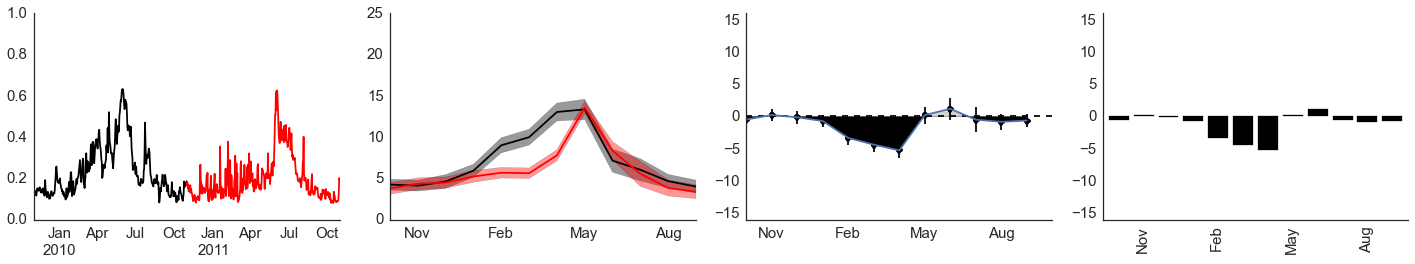

In [98]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetSum['REu'] = F_Unc_Wsum.weightedREu[F_Unc_Wsum.HY == 2010].ravel()
drySum['REu'] = F_Unc_Wsum.weightedREu[F_Unc_Wsum.HY == 2011].ravel()

wetYear.weightedRE.plot(ax = ax1, c = 'k')
dryYear.weightedRE.plot(ax = ax1, c = 'red')
wetSum.weightedRE.plot(ax = ax2, c = 'k')
drySum.weightedRE.plot(ax = ax2, c = 'red')

y1 = wetSum.weightedRE - (3 * wetSum.REu)
y2 = wetSum.weightedRE + (3 * wetSum.REu)
ax2.fill_between(wetSum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='k',
                 alpha = 0.4,
                 interpolate=True)

y1 = drySum.weightedRE - (3 * drySum.REu)
y2 = drySum.weightedRE + (3 * drySum.REu)
ax2.fill_between(drySum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='r',
                 alpha = 0.4,
                 interpolate=True)

ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (drySum.weightedRE - wetSum.weightedRE)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)
ax3.errorbar(np.arange(0,12,1), y2, yerr=2*(drySum.REu + wetSum.REu), fmt='o', color = 'k')

diffs = drySum.weightedRE - wetSum.weightedRE
diffs.plot(x = 'Season', kind = 'bar', width = 0.8, ax = ax4, color = 'k')
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(drySum.weightedRE - wetSum.weightedRE)

ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Nov','Feb','May','Aug'])
ax3.set_xticks([1,4,7,10])
ax3.set_xticklabels(['Nov','Feb','May','Aug'])
ax4.set_xticks([1,4,7,10])
ax4.set_xticklabels(['Nov','Feb','May','Aug'])
#### Axes
ax1.set_ylim([0,1])
ax2.set_ylim([0,25])
ax3.set_ylim([-16,16])
ax4.set_ylim([-16,16])

sns.despine()
plt.tight_layout()
plt.savefig('weightedSum_RECO.tif', dpi = 300)

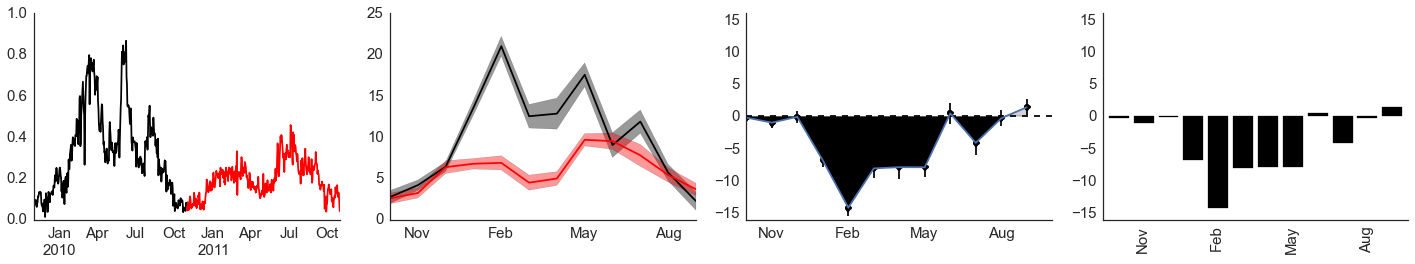

In [99]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetSum['GPPu'] = F_Unc_Wsum.weightedGPPu[F_Unc_Wsum.HY == 2010].ravel()
drySum['GPPu'] = F_Unc_Wsum.weightedGPPu[F_Unc_Wsum.HY == 2011].ravel()

wetYear.weightedGPP.plot(ax = ax1, c = 'k')
dryYear.weightedGPP.plot(ax = ax1, c = 'red')
wetSum.weightedGPP.plot(ax = ax2, c = 'k')
drySum.weightedGPP.plot(ax = ax2, c = 'red')

y1 = wetSum.weightedGPP - (3 * wetSum.GPPu)
y2 = wetSum.weightedGPP + (3 * wetSum.GPPu)
ax2.fill_between(wetSum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='k',
                 alpha = 0.4,
                 interpolate=True)

y1 = drySum.weightedGPP - (3 * drySum.GPPu)
y2 = drySum.weightedGPP + (3 * drySum.GPPu)
ax2.fill_between(drySum.index, y1,y2,
                 where=y2 >= y1, 
                 facecolor='r',
                 alpha = 0.4,
                 interpolate=True)

ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (drySum.weightedGPP - wetSum.weightedGPP)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)
ax3.errorbar(np.arange(0,12,1), y2, yerr=2*(drySum.GPPu + wetSum.GPPu), fmt='o', color = 'k')

diffs = drySum.weightedGPP - wetSum.weightedGPP
diffs.plot(x = 'Season', kind = 'bar', width = 0.8, ax = ax4, color = 'k')
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(drySum.weightedGPP - wetSum.weightedGPP)

ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Nov','Feb','May','Aug'])
ax3.set_xticks([1,4,7,10])
ax3.set_xticklabels(['Nov','Feb','May','Aug'])
ax4.set_xticks([1,4,7,10])
ax4.set_xticklabels(['Nov','Feb','May','Aug'])

#ax1.set_title(site)

#### Axes
ax1.set_ylim([0,1])
ax2.set_ylim([0,25])
ax3.set_ylim([-16,16])
ax4.set_ylim([-16,16])

sns.despine()
plt.tight_layout()
plt.savefig('weightedSum_GPP.tif', dpi = 300)